# Pythonで学ぶ有限要素法（三次元解析編）
線形等方弾性体に対する有限要素法による三次元解析のサンプルコードです．  
YouTubeチャンネル [大学生・技術者のための有限要素法](https://www.youtube.com/@fempython) の動画に対応しています．  
このnotebookには数式と対応するPythonスクリプトしか記載していないため，詳細な解説は対応する動画をご参照ください．

## 問2. 線形等方弾性体（三次元解析）

**以下，支配方程式再掲**

支配方程式
$$
\int_V \boldsymbol{\sigma}\cdot \delta \boldsymbol{\varepsilon} \mathrm{d}v = \int_V \boldsymbol{b}\cdot \delta \boldsymbol{u} \mathrm{d}v + \int_S \boldsymbol{t}\cdot \delta \boldsymbol{u} \mathrm{d}s
$$
構成式
$$
\sigma^{ij} = C^{\ ijkl}\varepsilon_{kl}
$$
弾性係数
$$
C^{\ ijkl}=\lambda \delta^{ij}\delta^{kl} + \mu (\delta^{ik}\delta^{jl} + \delta^{il}\delta^{jk})
\\
\lambda = \frac{E\nu }{(1+\nu )(1-2\nu )},\quad \mu = \frac{E}{2(1+\nu )}
\\
E=205\ \mathrm{GPa},\ \nu = 0.27
$$
離散化された支配方程式
$$
\int_{V^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[B]^{\mathrm{T}}\{ \sigma \} \mathrm{d}v^{\mathrm{e}} = \int_{V^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[N]\{ b \} \mathrm{d}v^{\mathrm{e}} + \int_{S^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[N]\{ t \} \mathrm{d}s^{\mathrm{e}}
$$
要素剛性行列
$$
\left[ K^{\mathrm{e}}_{ij} \right] = \frac{ \partial \left\{ f^{\mathrm{e}}_{\mathrm{in}i} \right\} }{\partial \left\{ u_j\right\} } = \int_{V^{\mathrm{e}}} [B]^{\mathrm{T}} [C] [B] \mathrm{d}v^{\mathrm{e}}
$$
要素剛性方程式
$$
[K^{\mathrm{e}}]\{ u \} = \{ f^{\mathrm{e}} \}
$$
全体剛性方程式
$$
[K]\{ u \} = \{ F \}
$$

## 1. メッシュ作成

行列計算用ライブラリ

In [ ]:
try:
    import cupy as np
    from cupyx.scipy.sparse import csr_matrix
    from cupyx.scipy.sparse.linalg import spsolve
    gpu_available = True
    print("CuPyを使用します(GPU利用可能)")
except ImportError:
    import numpy as np
    from scipy.sparse import csr_matrix
    from scipy.sparse.linalg import spsolve
    gpu_available = False
    print("NumPyを使用します(GPU利用不可)")

NumPyを使用します(GPU利用不可)


座標情報の実装

In [ ]:
# メッシュのサイズ
width, height, depth = 100e-3, 20e-3, 30e-3
# 分割数
nx, ny, nz = 10, 2, 3  # x方向, y方向, z方向
# 節点の座標を生成
x = np.linspace(0, width, nx + 1)
y = np.linspace(0, height, ny + 1)
z = np.linspace(0, depth, nz + 1)
Z, Y, X = np.meshgrid(z, y, x, indexing="ij")
coords = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
n_point, n_dof = coords.shape  # 全体節点数, 自由度数
f"全体節点数: {n_point}, 自由度数: {n_dof}"

'全体節点数: 132, 自由度数: 3'

コネクティビティーの実装

In [ ]:
# 要素-全体節点番号の対応
connectivity = []
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            n1 = k * (nx + 1) * (ny + 1) + j * (nx + 1) + i
            n2 = k * (nx + 1) * (ny + 1) + j * (nx + 1) + i + 1
            n3 = k * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i + 1
            n4 = k * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i
            n5 = (k + 1) * (nx + 1) * (ny + 1) + j * (nx + 1) + i
            n6 = (k + 1) * (nx + 1) * (ny + 1) + j * (nx + 1) + i + 1
            n7 = (k + 1) * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i + 1
            n8 = (k + 1) * (nx + 1) * (ny + 1) + (j + 1) * (nx + 1) + i
            connectivity.append([n1, n2, n3, n4, n5, n6, n7, n8])
n_element = len(connectivity)  # 要素数
f"要素数: {n_element}"

'要素数: 60'

境界条件（固定点）の実装

In [ ]:
# x=0の節点を固定． (節点番号, 自由度番号(x: 0, y: 1, z: 2))形式で格納
tolerance = 1e-8
fix_nodes = np.where(np.isclose(coords[:, 0], 0, atol=tolerance))[0]
fix_points = []
for ipnt in fix_nodes.tolist():
    fix_points.extend([(ipnt, 0), (ipnt, 1), (ipnt, 2)])

境界条件（荷重）の実装

In [ ]:
# x=xmax, y=ymaxの節点番号を取得
load_nodes = np.where(
    np.isclose(coords[..., 0], np.max(coords[..., 0]), atol=tolerance)
    & np.isclose(coords[..., 1], np.max(coords[..., 1]), atol=tolerance)
)[0]
load_nodes

array([ 32,  65,  98, 131])

In [ ]:
# 荷重 (節点番号, 自由度番号, 荷重)形式で格納
FORCE = -1000.0
applied_forces = [
    (32, 1, FORCE / nz / 2.0),
    (65, 1, FORCE / nz),
    (98, 1, FORCE / nz),
    (131, 1, FORCE / nz / 2.0),
]

メッシュ確認

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

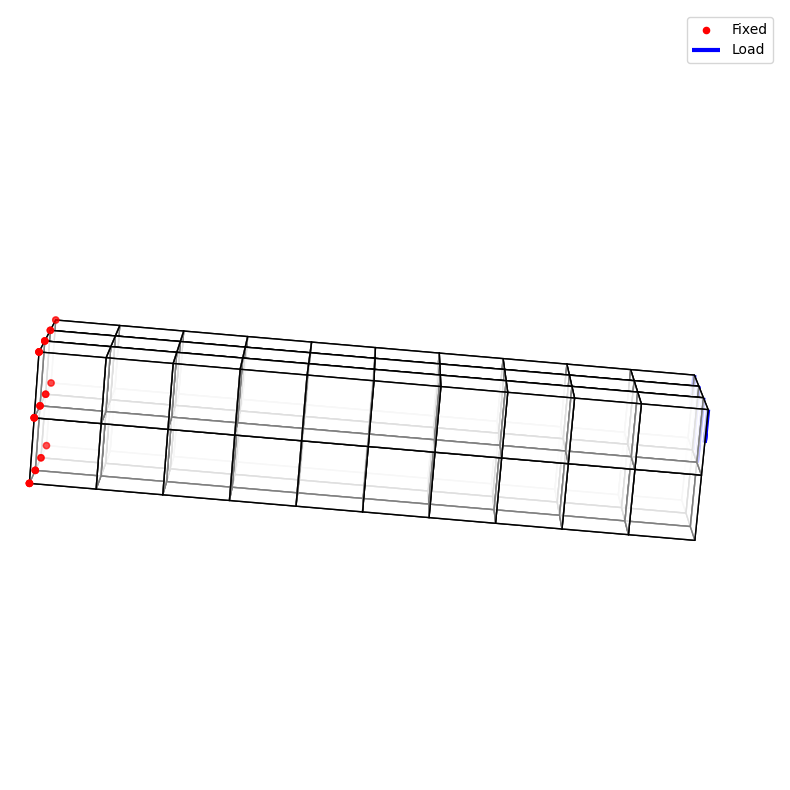

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 三次元要素の各面を構成する要素節点番号
face_nodes = np.array([
      [0, 1, 2, 3],
      [4, 5, 1, 0],
      [1, 5, 6, 2],
      [6, 7, 3, 2],
      [4, 0, 3, 7],
      [5, 4, 7, 6],
])

# 全要素の面を構成する全体節点番号
face_points = np.asarray(connectivity)[:, face_nodes]
# 全要素の面を構成する座標
face_coords = coords[face_points]

# 描画設定
kwargs = {
    "edgecolor": "k",
    "lw": 1,
    "cmap": "rainbow",
    "facecolors": "w",
    "alpha": 0.5,
    "facecolor": "w",
}

# メッシュの描画
vertices = face_coords.reshape(-1, 4, 3)
if gpu_available:
    vertices = np.asnumpy(vertices)
pcm = Poly3DCollection(vertices, **kwargs)
ax.add_collection3d(pcm)

if gpu_available:
    coords_cpu = np.asnumpy(coords)
else:
    coords_cpu = coords

# 固定点の描画
fix_pts = [ipnt for ipnt, _ in fix_points]
ax.scatter3D(
    coords_cpu[fix_pts, 0],
    coords_cpu[fix_pts, 1],
    coords_cpu[fix_pts, 2],
    color="r",
    s=20,
    label="Fixed",
)

# 荷重の描画
loads = np.zeros_like(coords)
load_pts = []
for ipnt, idof, force in applied_forces:
    loads[ipnt, idof] = force
    load_pts.append(ipnt)
loads /= np.max(np.abs(loads)) / max(width / nx, height / ny, depth / nz)
if gpu_available:
    loads_cpu = np.asnumpy(loads)
else:
    loads_cpu = loads
ax.quiver(
    coords_cpu[load_pts, 0],
    coords_cpu[load_pts, 1],
    coords_cpu[load_pts, 2],
    loads_cpu[load_pts, 0],
    loads_cpu[load_pts, 1],
    loads_cpu[load_pts, 2],
    linewidth=3,
    color="b",
    label="Load",
)

# プロット設定
ax.set_xlim([0, width * 1.1])
ax.set_ylim([0, depth * 1.1])
ax.set_zlim([0, height * 1.1])
# ax.set_box_aspect((width, depth, height))
ax.set_aspect("equal")
ax.view_init(elev=100, azim=-85)
ax.legend()
ax.axis("off")
plt.tight_layout()
plt.savefig("mesh_3d.png", dpi=300, transparent=True)

## 2. 形状関数の実装

自然座標系での積分点座標

In [ ]:
# 一次元での積分点座標
gauss_points_1d = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
# 一次元での積分点を並べて三次元上に配置する
r1, r2, r3 = np.meshgrid(gauss_points_1d, gauss_points_1d, gauss_points_1d)
# 三次元での積分点座標
gauss_points_3d = np.vstack([r1.flatten(), r2.flatten(), r3.flatten()]).T
# 各積分点での重み
weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

形状関数の取得
$$
N^1(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1-r_2)(1-r_3) \\
N^2(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1-r_2)(1-r_3) \\
N^3(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1+r_2)(1-r_3) \\
N^4(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1+r_2)(1-r_3) \\
N^5(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1-r_2)(1+r_3) \\
N^6(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1-r_2)(1+r_3) \\
N^7(r_1,r_2,r_3)=\frac{1}{8}(1+r_1)(1+r_2)(1+r_3) \\
N^8(r_1,r_2,r_3)=\frac{1}{8}(1-r_1)(1+r_2)(1+r_3)
$$

In [ ]:
def get_shape_func(rcods: np.ndarray) -> np.ndarray:
    """座標から対応する形状関数Nを取得する"""
    r1, r2, r3 = rcods[..., 0], rcods[..., 1], rcods[..., 2]
    N = np.array([
        0.125 * (1 - r1) * (1 - r2) * (1 - r3),  # N1
        0.125 * (1 + r1) * (1 - r2) * (1 - r3),  # N2
        0.125 * (1 + r1) * (1 + r2) * (1 - r3),  # N3
        0.125 * (1 - r1) * (1 + r2) * (1 - r3),  # N4
        0.125 * (1 - r1) * (1 - r2) * (1 + r3),  # N5
        0.125 * (1 + r1) * (1 - r2) * (1 + r3),  # N6
        0.125 * (1 + r1) * (1 + r2) * (1 + r3),  # N7
        0.125 * (1 - r1) * (1 + r2) * (1 + r3),  # N8
    ]).T
    return N

自然座標系におけるBマトリックスの取得
$$
B^1_1(r_1,r_2,r_3) = \frac{\partial N^1(r_1,r_2,r_3)}{\partial r_1}=-\frac{1}{8}(1-r_2)(1-r_3) \\
B^1_2(r_1,r_2,r_3) = \frac{\partial N^1(r_1,r_2,r_3)}{\partial r_2}=-\frac{1}{8}(1-r_1)(1-r_3) \\
B^1_3(r_1,r_2,r_3) = \frac{\partial N^1(r_1,r_2,r_3)}{\partial r_3}=-\frac{1}{8}(1-r_1)(1-r_2) \\ \vdots \\ B^8_1(r_1,r_2,r_3) = \frac{\partial N^8(r_1,r_2,r_3)}{\partial r_1}=-\frac{1}{8}(1+r_2)(1+r_3) \\
B^8_2(r_1,r_2,r_3) = \frac{\partial N^8(r_1,r_2,r_3)}{\partial r_2}=\frac{1}{8}(1-r_1)(1+r_3) \\
B^8_3(r_1,r_2,r_3) = \frac{\partial N^8(r_1,r_2,r_3)}{\partial r_3}=\frac{1}{8}(1-r_1)(1+r_2)
$$

In [ ]:
def get_bmat_natural(rcods: np.ndarray) -> np.ndarray:
    """座標から自然座標系でのBマトリックスを返す"""
    r1, r2, r3 = rcods[..., 0], rcods[..., 1], rcods[..., 2]
    # BI1 = ∂NI/∂r1 (:, 8)
    B1 = np.array([
        -0.125 * (1 - r2) * (1 - r3),  # B11
        0.125 * (1 - r2) * (1 - r3),  # B21
        0.125 * (1 + r2) * (1 - r3),  # B31
        -0.125 * (1 + r2) * (1 - r3),  # B41
        -0.125 * (1 - r2) * (1 + r3),  # B51
        0.125 * (1 - r2) * (1 + r3),  # B61
        0.125 * (1 + r2) * (1 + r3),  # B71
        -0.125 * (1 + r2) * (1 + r3),  # B81
    ]).T
    # BI2 = ∂NI/∂r2 (:, 8)
    B2 = np.array([
        -0.125 * (1 - r1) * (1 - r3),  # B12
        -0.125 * (1 + r1) * (1 - r3),  # B22
        0.125 * (1 + r1) * (1 - r3),  # B32
        0.125 * (1 - r1) * (1 - r3),  # B42
        -0.125 * (1 - r1) * (1 + r3),  # B52
        -0.125 * (1 + r1) * (1 + r3),  # B62
        0.125 * (1 + r1) * (1 + r3),  # B72
        0.125 * (1 - r1) * (1 + r3),  # B82
    ]).T
    # BI3 = ∂NI/∂r3 (:, 8)
    B3 = np.array([
        -0.125 * (1 - r1) * (1 - r2),  # B13
        -0.125 * (1 + r1) * (1 - r2),  # B23
        -0.125 * (1 + r1) * (1 + r2),  # B33
        -0.125 * (1 - r1) * (1 + r2),  # B43
        0.125 * (1 - r1) * (1 - r2),  # B53
        0.125 * (1 + r1) * (1 - r2),  # B63
        0.125 * (1 + r1) * (1 + r2),  # B73
        0.125 * (1 - r1) * (1 + r2),  # B83
    ]).T
    return np.stack((B1, B2, B3), axis=-1)  # (:, 8, 3)

# 積分点座標から自然座標系でのBマトリックスを作成
bmat_nat = get_bmat_natural(gauss_points_3d)

全体座標系におけるBマトリックスと重みの取得
$$
B^I_i
= \frac{\partial N^I}{\partial x_i}
= \frac{\partial N^I}{\partial r_j}  \frac{\partial r_j}{\partial x_i}
= B^I_{\mathrm{nat}\ j}\ J_{ji}^{-1}
$$

In [ ]:
def get_bmatrix(ncods: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """全体座標から全体座標系でのBマトリックスと重み×ヤコビ行列式を取得する"""
    # ヤコビ行列 Jij = BnatIj * xIi
    jacob = np.einsum("gIj,...Ii->...gij", bmat_nat, ncods)
    # ヤコビ行列指揮 detJ
    detJ = np.sqrt(np.linalg.det(np.einsum("...gki,...gkj->...gij", jacob, jacob)))
    # J^-1ji
    jinv = np.linalg.inv(jacob)
    # 全体座標系でのBマトリックス BIi = BnatIj * J^-1ji
    bmat_phys = np.einsum("gIj,...gji->...gIi", bmat_nat, jinv)
    # 重み×ヤコビ行列式 w * detJ
    wdetJ = weights * detJ
    # 全体座標系でのBマトリックスと重み×ヤコビ行列式を返す
    return bmat_phys, wdetJ

## 3. 支配方程式の実装

弾性係数の実装
$$
[C] = \begin{bmatrix} \lambda + 2\mu & \lambda & \lambda & 0 & 0 & 0 \\ \lambda & \lambda + 2\mu & \lambda & 0 & 0 & 0 \\ \lambda & \lambda & \lambda + 2\mu & 0 & 0 & 0 \\ 0 & 0 & 0 & \mu & 0 & 0 \\ 0 & 0 & 0 & 0 & \mu & 0 \\ 0 & 0 & 0 & 0 & 0 & \mu \end{bmatrix}
$$

In [ ]:
# 鋼材を想定
# ヤング率 E
YOUNG = 205e9
# ポアソン比 ν
POISSON = 0.27
# λ = Eν/((1+ν)(1-2ν))
c_lambda = YOUNG * POISSON / ((1.0 + POISSON) * (1.0 - 2.0 * POISSON))
# μ = E/(2*(1+ν))
c_mu = YOUNG / (2.0 * (1.0 + POISSON))
# 弾性係数行列 C
Cmatrix = np.array([
    [c_lambda + 2 * c_mu, c_lambda, c_lambda, 0, 0, 0],
    [c_lambda, c_lambda + 2 * c_mu, c_lambda, 0, 0, 0],
    [c_lambda, c_lambda, c_lambda + 2 * c_mu, 0, 0, 0],
    [0, 0, 0, c_mu, 0, 0],
    [0, 0, 0, 0, c_mu, 0],
    [0, 0, 0, 0, 0, c_mu],
])

全体剛性行列の初期化

In [ ]:
# 全体剛性 (全自由度数 = 次元(n_dof) * 全節点数(n_point))
Kmatrix = np.zeros((n_dof * n_point, n_dof * n_point))
Fvector = np.zeros(n_dof * n_point)
# Bマトリックスの行数 (変形に関する自由度)
# n_dfdof = 3  # 二次元解析
n_dfdof = 6  # 三次元解析
# 要素を構成する節点数(今回はすべて六面体一次)
n_node = 8
# 要素内の積分点数(今回はすべて積分次数2)
n_intgp = 8  # 8=2^3
# バッチサイズ(同時に計算する要素数)
batch_size = 7

要素剛性行列の計算・全体剛性行列への足し込み
$$
\begin{aligned}
\left[ K^{\mathrm{e}} \right]
&= \int_{V^{\mathrm{e}}} [B]^{\mathrm{T}} [C] [B] \mathrm{d}v^{\mathrm{e}} \\
& \approx \sum_{I_{\mathrm{g}}=1}^{N_{\mathrm{g}}}[B]^{\mathrm{T}} [C] [B]w_{I_{\mathrm{g}}} \det \boldsymbol{J} \\
&= \sum_{I_{\mathrm{g}}=1}^{N_{\mathrm{g}}} \begin{bmatrix} \frac{\partial N^1}{\partial x_1} & 0 & 0 & 0 & \frac{\partial N^1}{\partial x_3} & \frac{\partial N^1}{\partial x_2} \\ 0 & \frac{\partial N^1}{\partial x_2} & 0 & \frac{\partial N^1}{\partial x_3} & 0 & \frac{\partial N^1}{\partial x_1} \\ 0 & 0 & \frac{\partial N^1}{\partial x_3} & \frac{\partial N^1}{\partial x_2} & \frac{\partial N^1}{\partial x_1} & 0 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\  \frac{\partial N^N}{\partial x_1} & 0 & 0 & 0 & \frac{\partial N^N}{\partial x_3} & \frac{\partial N^N}{\partial x_2} \\ 0 & \frac{\partial N^N}{\partial x_2} & 0 & \frac{\partial N^N}{\partial x_3} & 0 & \frac{\partial N^N}{\partial x_1} \\ 0 & 0 & \frac{\partial N^N}{\partial x_3} & \frac{\partial N^N}{\partial x_2} & \frac{\partial N^N}{\partial x_1} & 0
\end{bmatrix} \begin{bmatrix} \lambda + 2\mu & \lambda & \lambda & 0 & 0 & 0 \\ \lambda & \lambda + 2\mu & \lambda & 0 & 0 & 0 \\ \lambda & \lambda & \lambda + 2\mu & 0 & 0 & 0 \\ 0 & 0 & 0 & \mu & 0 & 0 \\ 0 & 0 & 0 & 0 & \mu & 0 \\ 0 & 0 & 0 & 0 & 0 & \mu \end{bmatrix} \begin{bmatrix} \frac{\partial N^1}{\partial x_1} & 0 & 0 & \cdots & \frac{\partial N^N}{\partial x_1} & 0 & 0 \\ 0 & \frac{\partial N^1}{\partial x_2} & 0 & \cdots & 0 & \frac{\partial N^N}{\partial x_2} & 0 \\ 0 & 0 & \frac{\partial N^1}{\partial x_3} & \cdots & 0 & 0 & \frac{\partial N^N}{\partial x_3} \\ 0 & \frac{\partial N^1}{\partial x_3} & \frac{\partial N^1}{\partial x_2} & \cdots & 0 & \frac{\partial N^N}{\partial x_3} & \frac{\partial N^N}{\partial x_2} \\ \frac{\partial N^1}{\partial x_3} & 0 & \frac{\partial N^1}{\partial x_1} & \cdots & \frac{\partial N^N}{\partial x_3} & 0 & \frac{\partial N^N}{\partial x_1} \\ \frac{\partial N^1}{\partial x_2} & \frac{\partial N^1}{\partial x_1} & 0 & \cdots & \frac{\partial N^N}{\partial x_2} & \frac{\partial N^N}{\partial x_1} & 0 \end{bmatrix} w_{I_{\mathrm{g}}} \det \boldsymbol{J}
\end{aligned}
$$

In [ ]:
# バッチサイズ分一気に計算
for idx in range(0, n_element, batch_size):
    # 同時に計算する要素番号
    batch = list(range(idx, min(idx + batch_size, n_element)))

    # Bマトリックスと重み*ヤコビアンの取得
    Bmatrix, wdetJv = get_bmatrix(coords[np.asarray(connectivity)[batch]])
    # 行列[B]の作成
    Bd = np.zeros((len(batch), n_intgp, n_dfdof, n_dof * n_node))
    Bd[..., 0, ::n_dof] = Bmatrix[..., 0]
    Bd[..., 3, ::n_dof] = Bmatrix[..., 1]
    Bd[..., 5, ::n_dof] = Bmatrix[..., 2]
    Bd[..., 1, 1::n_dof] = Bmatrix[..., 1]
    Bd[..., 3, 1::n_dof] = Bmatrix[..., 0]
    Bd[..., 4, 1::n_dof] = Bmatrix[..., 2]
    Bd[..., 2, 2::n_dof] = Bmatrix[..., 2]
    Bd[..., 4, 2::n_dof] = Bmatrix[..., 1]
    Bd[..., 5, 2::n_dof] = Bmatrix[..., 0]

    # 要素剛性行列の計算
    ke = np.einsum("...gki, kl, ...glj, ...g -> ...ij", Bd, Cmatrix, Bd, wdetJv)

    # 全体剛性行列への足し込み K <- Ke
    for i, ielm in enumerate(batch):
        for inod in range(n_node):
            for jnod in range(n_node):
                for idof in range(n_dof):
                    for jdof in range(n_dof):
                        ipnt = connectivity[ielm][inod]
                        jpnt = connectivity[ielm][jnod]
                        Kmatrix[n_dof * ipnt + idof, n_dof * jpnt + jdof] += ke[
                            i, n_dof * inod + idof, n_dof * jnod + jdof
                        ]

## 4. 境界条件の適用

境界条件（荷重）

In [ ]:
# 境界条件(荷重)
for ipnt, idof, force in applied_forces:
    # 荷重が加わる全体自由度番号
    idx = n_dof * ipnt + idof
    # 右辺外力ベクトルに荷重を加える
    Fvector[idx] += force

境界条件（固定端）

In [ ]:
# ペナルティー係数*全体剛性行列成分の最大値
penalty = 1.0e8 * np.max(np.abs(Kmatrix))
for ipnt, idof in fix_points:
    # 固定点の全体自由度番号
    idx = n_dof * ipnt + idof
    # 全体剛性行列の対角成分にペナルティーを加える
    Kmatrix[idx, idx] += penalty

## 5. 剛性方程式の求解

全体剛性方程式$[K]\{U\}=\{F\}$を解く

In [ ]:
Kmatrix = csr_matrix(Kmatrix)
Uvector = spsolve(Kmatrix, Fvector)

解析結果のプロット

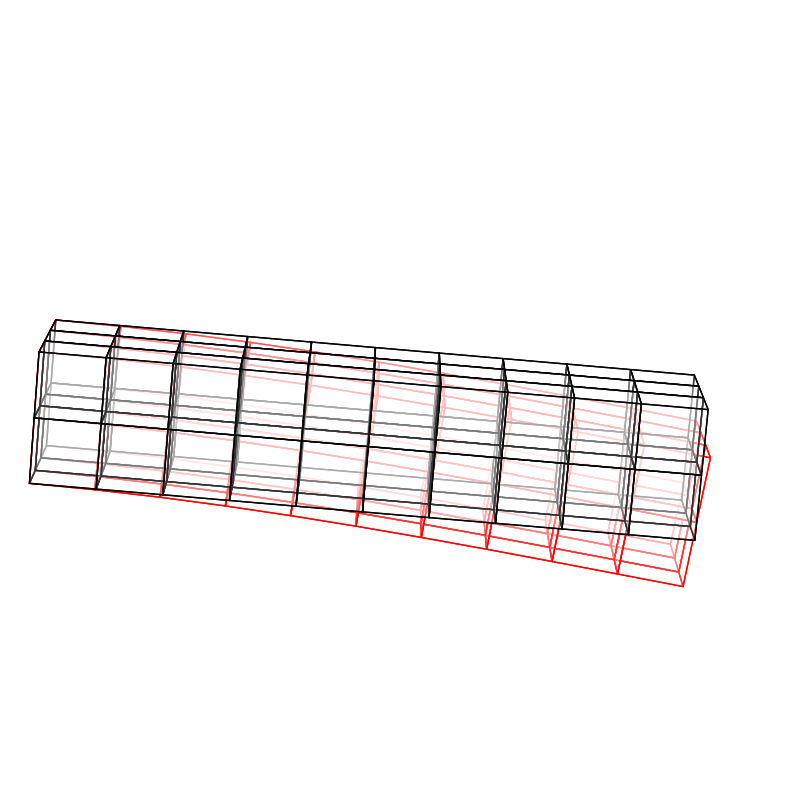

In [ ]:
# 変位を1000倍にしてプロット
displacement = Uvector.reshape(n_point, n_dof)
deformed_coords = coords + 100 * displacement

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 変形前のメッシュを黒，変形後のメッシュを赤色でプロット
for cod, c in zip((coords, deformed_coords), ("black", "red")):
    # 全要素の面を構成する全体節点番号
    face_points = np.asarray(connectivity)[:, face_nodes]
    # 全要素の面を構成する座標
    face_coords = cod[face_points]

    # 描画設定
    kwargs = {
        "edgecolor": c,
        "lw": 1,
        "cmap": "rainbow",
        "facecolors": "w",
        "alpha": 0.2,
        "facecolor": "w",
    }

    # メッシュ描画
    vertices = face_coords.reshape(-1, 4, 3)
    if gpu_available:
        vertices = np.asnumpy(vertices)
    pcm = Poly3DCollection(vertices, **kwargs)
    ax.add_collection3d(pcm)

# プロット設定
ax.set_xlim([0, width * 1.1])
ax.set_ylim([0, depth * 1.1])
ax.set_zlim([0, height * 1.1])
# ax.set_box_aspect((width, depth, height))
ax.set_aspect("equal")
ax.view_init(elev=100, azim=-85)
ax.axis("off")
plt.tight_layout()
plt.savefig("result_3d.png", dpi=300, transparent=True)

## 6. VTKファイルへの結果出力

In [ ]:
from pathlib import Path

Offsets（累計節点数）

In [ ]:
offsets = np.cumsum(np.array([len(cell) for cell in connectivity]))

要素タイプ
- [The VTK User's Guide](https://vtk.org/wp-content/uploads/2021/08/VTKUsersGuide.pdf)参照
- 六面体一次要素はVTK_HEXAHEDRON（12番）に対応
- 二次元解析で用いた四角形一次要素はVTK_QUAD（9番）に対応

In [ ]:
cell_type = 12
cell_types = np.full(n_element, cell_type, dtype=np.uint8)

出力ファイル

In [ ]:
file_path = Path("result.vtu")

VTKファイルへの書き込み

In [ ]:
with file_path.open("w") as f:
    # headerの書き込み
    f.write("<?xml version='1.0'?>\n")
    f.write(
        "<VTKFile type='UnstructuredGrid' version='0.1' byte_order='LittleEndian'>\n"
    )
    f.write("<UnstructuredGrid>\n")
    f.write(f"<Piece NumberOfPoints='{n_point}' NumberOfCells='{n_element}'>\n")

    # 座標の書き込み
    f.write("<Points>\n")
    f.write("<DataArray type='Float32' NumberOfComponents='3' format='ascii'>\n")
    np.savetxt(f, deformed_coords, fmt="%.6e")
    f.write("</DataArray>\n")
    f.write("</Points>\n")

    # 要素（Cells）の書き込み
    f.write("<Cells>\n")

    # コネクティビティー
    f.write("<DataArray type='Int32' Name='connectivity' format='ascii'>\n")
    np.savetxt(f, np.array(connectivity), fmt="%d")
    f.write("</DataArray>\n")

    # Offsets
    f.write("<DataArray type='Int32' Name='offsets' format='ascii'>\n")
    np.savetxt(f, offsets, fmt="%d")
    f.write("</DataArray>\n")

    # 要素タイプ
    f.write("<DataArray type='UInt8' Name='types' format='ascii'>\n")
    np.savetxt(f, cell_types, fmt="%d")
    f.write("</DataArray>\n")

    f.write("</Cells>\n")

    # 節点量（変位）の書き込み
    f.write("<PointData>\n")
    f.write(
        "<DataArray type='Float32' NumberOfComponents='3' Name='Displacement' format='ascii'>\n"
    )
    np.savetxt(f, displacement, fmt="%.6e")
    f.write("</DataArray>\n")
    f.write("</PointData>\n")

    # footerの書き込み
    f.write("</Piece>\n")
    f.write("</UnstructuredGrid>\n")
    f.write("</VTKFile>\n")

以上